In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
import scipy.stats as stats
from scipy.stats import pearsonr
import random
import datetime
import scipy
import math

from params import *
from utils import *
from key import *

## 1. Read and Preprocess Data

In [75]:
sshtunnel.SSH_TIMEOUT = 5.0
sshtunnel.TUNNEL_TIMEOUT = 5.0

with sshtunnel.SSHTunnelForwarder(
    ('ssh.pythonanywhere.com'),
    ssh_username='Grawi', ssh_password=ssh_password,
    remote_bind_address=('Grawi.mysql.pythonanywhere-services.com', 3306)
) as tunnel:
    print("Successfully connected to Pythonanywhere")
    connection = MySQLdb.connect(
        user='Grawi',
        passwd=db_password,
        host='127.0.0.1', port=tunnel.local_bind_port,
        db='Grawi$Interactive_quiz_database',
    )
    # Do stuff
    print("Successfully connected to database")
    
    try:
        cursor = connection.cursor()
        df_1 = pd.read_sql("SELECT * FROM condition_1;", connection)
        df_1["type"] = "condition_1"
        df_2 = pd.read_sql("SELECT * FROM condition_2;", connection)
        df_2["type"] = "condition_2"
        df_3 = pd.read_sql("SELECT * FROM condition_3;", connection)
        df_3["type"] = "condition_3"
        print(f"Data read finished, length: condition 1 length {len(df_1)}, condition 2 length {len(df_2)}, condition 3 length {len(df_3)}")
    
    except Exception as e:
        print("Error:", e)
    
    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

df = pd.concat([df_1, df_2, df_3])
df.head

Successfully connected to Pythonanywhere
Successfully connected to database
Data read finished, length: condition 1 length 297, condition 2 length 600, condition 3 length 297


,participantId,assignmentId,projectId,attention_passed,total_time,identity_choices,ideologies,bot_detected,submit_time,non_ideology_answers,additional_answers,reason,type,ideology_answers,labels
0,000D1F259F974E9682C4EBD24445552A,ac2fc22e-048d-4833-bfbb-9008f0173a32,2bbe96aa-ba11-4e39-b176-771f624a3e4d,1,194.568,"[[14, 2], [0, 4], [4, 0]]",None,33,2023-10-11 16:49:52,"[{""answers"": [-100, 3, -100], ""time_to_answer""...","[[0, 2, 0]]",I felt the choices were picked randomly,condition_1,NaN,NaN
1,008A190019B6486B9A3B1E4D019EAEF1,41f53682-12f8-4838-9221-fa774c2dd90f,2bbe96aa-ba11-4e39-b176-771f624a3e4d,1,277.584,"[[18, 0], [8, 1], [0, 4]]",None,53,2023-10-11 16:41:19,"[{""answers"": [-100, 1, -100], ""time_to_answer""...","[[0, 1, -1]]",I chose bot because I felt that none of the tr...,condition_1,NaN,NaN
2,0162A54DBD78426689292407F226B9B2,1110b64e-2a28-4945-8d41-15c725a5589e,2bbe96aa-ba11-4e39-b176-771f624a3e4d,1,295.912,"[[6, 4], [14, 2], [8, 5]]",None,3,2023-10-11 16:43:30,"[{""answers"": [-100, 2, -100], ""time_to_answer""...","[[-0.1, -2, -0.1]]",they were very fast and the answers I think mo...,condition_1,NaN,NaN
3,05F5987ECD4D492E96AF3637F44C1FD5,feffe294-c133-4b10-84ea-5e8673101baa,2bbe96aa-ba11-4e39-b176-771f624a3e4d,1,188.531,"[[15, 3], [11, 2], [5, 4]]",None,66,2023-10-11 16:43:23,"[{""answers"": [-100, -1.8, -100], ""time_to_answ...","[[-0.8, 0.9, -0.6]]",,condition_1,NaN,NaN
4,06D0A0B7823B4E6BBFEFA270E8EEB2F7,a836d1d4-e4eb-43b1-9524-f5edbad34eb4,2bbe96aa-ba11-4e39-b176-771f624a3e4d,1,282.535,"[[9, 4], [19, 5], [17, 3]]",None,25,2023-10-11 16:47:34,"[{""answers"": [-100, 2.2, -100], ""time_to_answe...","[[-0.7, 1.1, -0.7]]",,condition_1,NaN,NaN


In [13]:
for i in range(3):
    id_attention_failed = df[i][df[i]['attention_passed'] == 0]['participantId'].tolist()
    print(f"For condition {i + 1}, {len(id_attention_failed)} participants failed attention passed: {id_attention_failed}")
    df[i] = df[i][df[i]['attention_passed'] == True]
    columns_to_drop = ['assignmentId', 'projectId', 'attention_passed', 'total_time', 'identity_choices', 'ideologies', 'submit_time']
    df[i].drop(columns_to_drop, inplace=True, axis=1)
    print(f"There are {len(df[i])} valid data collected\n")
    df[i].set_index('participantId', inplace=True)
df[0].head()

KeyError: 'attention_passed'

### Bot detection

In [5]:
def get_bot_detection_num(detection):
    first = detection // 10
    second = detection % 10
    return int(first == 3) + int(second == 3)

ratio_at_least_one_bot_detected = []
ratio_one_bot_detected = []
ratio_two_bots_detected = []

for i in range(3):
    df[i]['bot_detection_num'] = df[i]['bot_detected'].apply(get_bot_detection_num)
    ratio_at_least_one_bot_detected.append(((df[i]['bot_detection_num'] >= 1).sum()) / (len(df[i])))
    ratio_one_bot_detected.append(((df[i]['bot_detection_num'] == 1).sum()) / (len(df[i])))
    ratio_two_bots_detected.append(((df[i]['bot_detection_num'] == 2).sum()) / (len(df[i])))
    print(f"For condition {i + 1}, there are {ratio_at_least_one_bot_detected[i]:.2%} participants who detected at least one bot")
    print(f"For condition {i + 1}, there are {ratio_one_bot_detected[i]:.2%} participants who detected one bot")
    print(f"For condition {i + 1}, there are {ratio_two_bots_detected[i]:.2%} participants who detected at two bots")
    df[i].drop(['reason', 'bot_detection_num'], axis=1, inplace=True)

For condition 1, there are 33.22% participants who detected at least one bot
For condition 1, there are 14.19% participants who detected one bot
For condition 1, there are 19.03% participants who detected at two bots
For condition 2, there are 29.40% participants who detected at least one bot
For condition 2, there are 12.82% participants who detected one bot
For condition 2, there are 16.58% participants who detected at two bots
For condition 3, there are 29.86% participants who detected at least one bot
For condition 3, there are 14.24% participants who detected one bot
For condition 3, there are 15.62% participants who detected at two bots


## Whether labels are consistent until the end

In [6]:
# def generate_pairs(row):
#     ret = [0, 0, 0]
#     if 'ideology_answers' in row.index:
#         for ideology_answer in row['ideology_answers']:
#             for i in range(3):
#                 try:
#                     ret[i] += abs(ideology_answer['answers'][i] - ideology_answer['answers'][1])
#                 except Exception as e:
#                     None
    
#     new_rows = []
#     for idx in range(3):
#         bot_detection = False
#         if idx == 0:
#             bot_detection = (row['bot_detected'] // 10) == 3
#         elif idx == 2:
#             bot_detection = (row['bot_detected'] % 10) == 3

#         new_row = {
#             "participantId": row.name,
#             "idx": idx,
#             "bot_detection": bot_detection, 
#             "reported_ideology": row['additional_answers'][0][idx]
#         }

#         if "labels" in row.index:
#             new_row["labels"] = row['labels'][idx]
#         if "ideology_answers" in row.index:
#             new_row['answer_distance'] = ret[idx]
        
#         new_rows.append(new_row)
#     return pd.DataFrame(new_rows)

# df_pairs = [None, None, None]
# for i in range(3):
#     list_of_df_pairs = df[i].apply(generate_pairs, axis=1).tolist()
#     df_pairs[i] = pd.concat(list_of_df_pairs, ignore_index=True)
#     df_pairs[i].set_index("participantId", inplace=True)
#     df_pairs[i].to_csv(f"data/condition_{i + 1}-pair.csv")

# df_label_consistency = pd.concat([df_pairs[1], df_pairs[2]])
# df_label_consistency.head()

# def ideology_is_consistent(row):
#     labels = set(row['labels'])
#     reported_ideology = row['reported_ideology']
#     if len(set([label_map["Conservative"], label_map["Somewhat conservative"], label_map["Liberal"], label_map["Somewhat liberal"]]).intersection(labels)) == 0:
#         return True
    
#     if label_map["Conservative"] in row['labels'] or label_map["Somewhat conservative"] in row['labels']:
#         if reported_ideology > 0:
#             return True
#     if label_map["Liberal"] in row['labels'] or label_map["Somewhat liberal"] in row['labels']:
#         if reported_ideology < 0:
#             return True
#     return False

# df_label_consistency['label_consistency'] = df_label_consistency.apply(ideology_is_consistent, axis=1)

# print(f"Label consistency rate: {df_label_consistency['label_consistency'].mean():.2%}")
# print(f"Correlation: {pearsonr(df_label_consistency['answer_distance'], df_label_consistency['ideology_distance'])}")

In [7]:
# def get_answer_distances(ideology_answers):
#     if type(ideology_answers) != list:
#         return [0, 0]
#     ret = [0, 0]
#     for ideology_answer in ideology_answers:
#         # print(ideology_answer, type(ideology_answer))
#         ret[0] += abs(ideology_answer['answers'][0] - ideology_answer['answers'][1])
#         ret[1] += abs(ideology_answer['answers'][2] - ideology_answer['answers'][1])
#     return ret

# def get_ideology_distances(additional_answers):
#     return [abs(additional_answers[0][0] - additional_answers[0][1]), abs(additional_answers[0][2] - additional_answers[0][1])]

# df_answer_analysis['answer_distances'] = df_answer_analysis['ideology_answers'].apply(get_answer_distances)
# df_answer_analysis['ideology_distances'] = df_answer_analysis['additional_answers'].apply(get_ideology_distances)
# # df_answer_analysis.drop(['ideology_answers', 'additional_answers', 'bot_same_ideology', 'ideologies'], axis=1, inplace=True)
# df_answer_analysis.head()
# df_bots_exploded = df_answer_analysis.explode(['answer_distances', 'ideology_distances'])
# df_bots_exploded['answer_distances'] = df_bots_exploded['answer_distances'].astype(int)
# df_bots_exploded['ideology_distances'] = df_bots_exploded['ideology_distances'].astype(float)
# df_bots_exploded.head()

In [8]:
# pearsonr(df_bots_exploded['answer_distances'], df_bots_exploded['ideology_distances'])

In [9]:
# def get_affection(labels, type):
#     bot_labels = set(row['labels'])
#     if type == "competence":
#         good_label_num = len(set([label_map['Competent']]).intersection(bot_labels))
#         bad_label_num = len(set([label_map['Incompetent']]).intersection(bot_labels))
#     elif type == "warmth":
#         good_label_num = len(set([label_map['Kind']]).intersection(bot_labels))
#         bad_label_num = len(set([label_map['Indifferent']]).intersection(bot_labels))  
#     return good_label_num - bad_label_num


# for condition in range(3):
#     df[condition]['condition'] = condition + 1
    
# df_total = pd.concat([df[condition] for condition in range(3)])
# df_total.reset_index(inplace=True)
# df_total = df_total.explode(['additional_answers'])
# df_total['valid_ideologies'] = df_total['additional_answers'].apply(lambda x: int(x[0]) != 0 or int(x[1]) != 0 or int(x[2]) != 0)
# df_exploded = df_total.explode(['non_ideology_answers'])
# df_exploded['bot_detection'] = df_exploded['bot_detected'].apply(lambda num: [num // 10 == 3, False, num % 10 == 3])
# df_exploded['answer'] = df_exploded['non_ideology_answers'].apply(lambda x: x['answers'])
# df_exploded['idx_of_question'] = df_exploded['non_ideology_answers'].apply(lambda x: x['idx_of_question'])
# df_exploded['who_answers_first'] = df_exploded['non_ideology_answers'].apply(lambda x: x['who_answers_first'])
# df_exploded['ideology'] = df_exploded['additional_answers']
# df_exploded['who'] = np.nan
# df_exploded['who'] = df_exploded['who'].apply(lambda x: [0, 1, 2])
# df_exploded['labels'] = df_exploded['labels'].apply(lambda x: [None, None, None] if isinstance(pd.isna(x), bool) else x)
# df_each_subject = df_dropped.explode(['ideology', 'answer', 'bot_detection', 'labels', 'who'])
# df_dropped = df_exploded.drop(['bot_detected', 'non_ideology_answers', 'ideology_answers', 'additional_answers'], axis=1)
# df_each_subject = df_each_subject[['participantId', 'idx_of_question', 'who', 'ideology', 'answer', 'condition', 'who_answers_first', 'bot_detection', 'labels', 'valid_ideologies']]
# df_reindexed = df_each_subject.set_index("participantId")
# df_reindexed.to_csv("data/condition.csv")
# df_reindexed.tail()

## Compare Average Distances and Plot The Figure

In [10]:
each_answer = [None, None, None]

def detect_first_answering_bot(row):
    if row['who_answers_first'] == 0:
        return (row['bot_detected'] // 10) == 3
    else:
        return (row['bot_detected'] % 10) == 3

def get_ideology_distance(row):
    who_answers_first = row['who_answers_first']
    additional_answers = row['additional_answers'][0]
    if who_answers_first != 1:
        return [abs(additional_answers[who_answers_first] - additional_answers[1])]
    else:
        return [abs(additional_answers[0] - additional_answers[1]), abs(additional_answers[2] - additional_answers[1])]

def get_target_ideology(row):
    ideologies = row['additional_answers'][0]
    if row['who_answers_first'] == 1:
        return [float(ideologies[0]), float(ideologies[2])]
    else:
        return [float(ideologies[row['who_answers_first']])]

def calculate_answer_distance(row):
    if row['who_answers_first'] != 1:
        return abs(row['answers'][1] - row['answers'][row['who_answers_first']])
    else:
        # return (row['answers'][1] ** 2 + 9) / 6
        return abs(row['answers'][1] - (np.random.random() * 6 - 3))

def get_target_answer(row):
    if row['who_answers_first'] == 1:
        return [np.random.uniform(-3, 3), np.random.uniform(-3, 3)]
    else:
        return [row['answers'][row['who_answers_first']]]
    
def get_affection(row, type):
    bot_labels = set(row['labels'])
    if type == "competence":
        good_label_num = len(set([label_map['Competent']]).intersection(bot_labels))
        bad_label_num = len(set([label_map['Incompetent']]).intersection(bot_labels))
    elif type == "warmth":
        good_label_num = len(set([label_map['Kind']]).intersection(bot_labels))
        bad_label_num = len(set([label_map['Indifferent']]).intersection(bot_labels))  
    return good_label_num - bad_label_num

def has_SCM_label(labels):
    if len(set([4, 5]).intersection(set(labels))) > 0 or len(set([8, 9]).intersection(set(labels))) > 0:
        return True
    return False

for i in range(3):
    df[i]['ideology_all_zeros'] = df[i]['additional_answers'].apply(lambda x: x[0][0] == 0 and x[0][1] == 0 and x[0][2] == 0)
    each_answer[i] = df[i].explode('non_ideology_answers')
    each_answer[i]['answers'] = each_answer[i].apply(lambda row: row['non_ideology_answers']['answers'], axis=1)
    each_answer[i]['idx_of_question'] = each_answer[i].apply(lambda row: row['non_ideology_answers']['idx_of_question'], axis=1)
    each_answer[i]['who_answers_first'] = each_answer[i].apply(lambda row: row['non_ideology_answers']['who_answers_first'], axis=1)
    each_answer[i]['bot_detection'] = each_answer[i].apply(detect_first_answering_bot, axis=1)
    each_answer[i]['ideology'] = each_answer[i]['additional_answers'].apply(lambda x: float(x[0][1]))
    each_answer[i]['bot_ideology'] = each_answer[i].apply(get_target_ideology, axis=1)
    each_answer[i]['ideology_distance'] = each_answer[i].apply(get_ideology_distance, axis=1)
    each_answer[i]['answer'] = each_answer[i]['answers'].apply(lambda x: x[1])
    each_answer[i]['bot_answer'] = each_answer[i].apply(get_target_answer, axis=1)
    each_answer[i]['answer_distance'] = each_answer[i].apply(calculate_answer_distance, axis=1)

    each_answer[i].drop(['non_ideology_answers', 'bot_detected', 'additional_answers', 'answers'], axis=1, inplace=True)
    
    if 'ideology_answers' in each_answer[i].columns:
        each_answer[i].drop(['ideology_answers'], axis=1, inplace=True)

for i in [1, 2]:
    each_answer[i]['labels'] = each_answer[i].apply(lambda row: row['labels'][row['who_answers_first']], axis=1)
    each_answer[i]['affection_competence'] = each_answer[i].apply(get_affection, axis=1, type="competence")
    each_answer[i]['affection_warmth'] = each_answer[i].apply(get_affection, axis=1, type="warmth")
    each_answer[i].drop(['labels'], axis=1, inplace=True)

for i in range(3):
    each_answer[i]['condition'] = i + 1

condition_data = pd.concat([each_answer[i] for i in range(3)])
condition_data.to_csv("data/condition.csv")

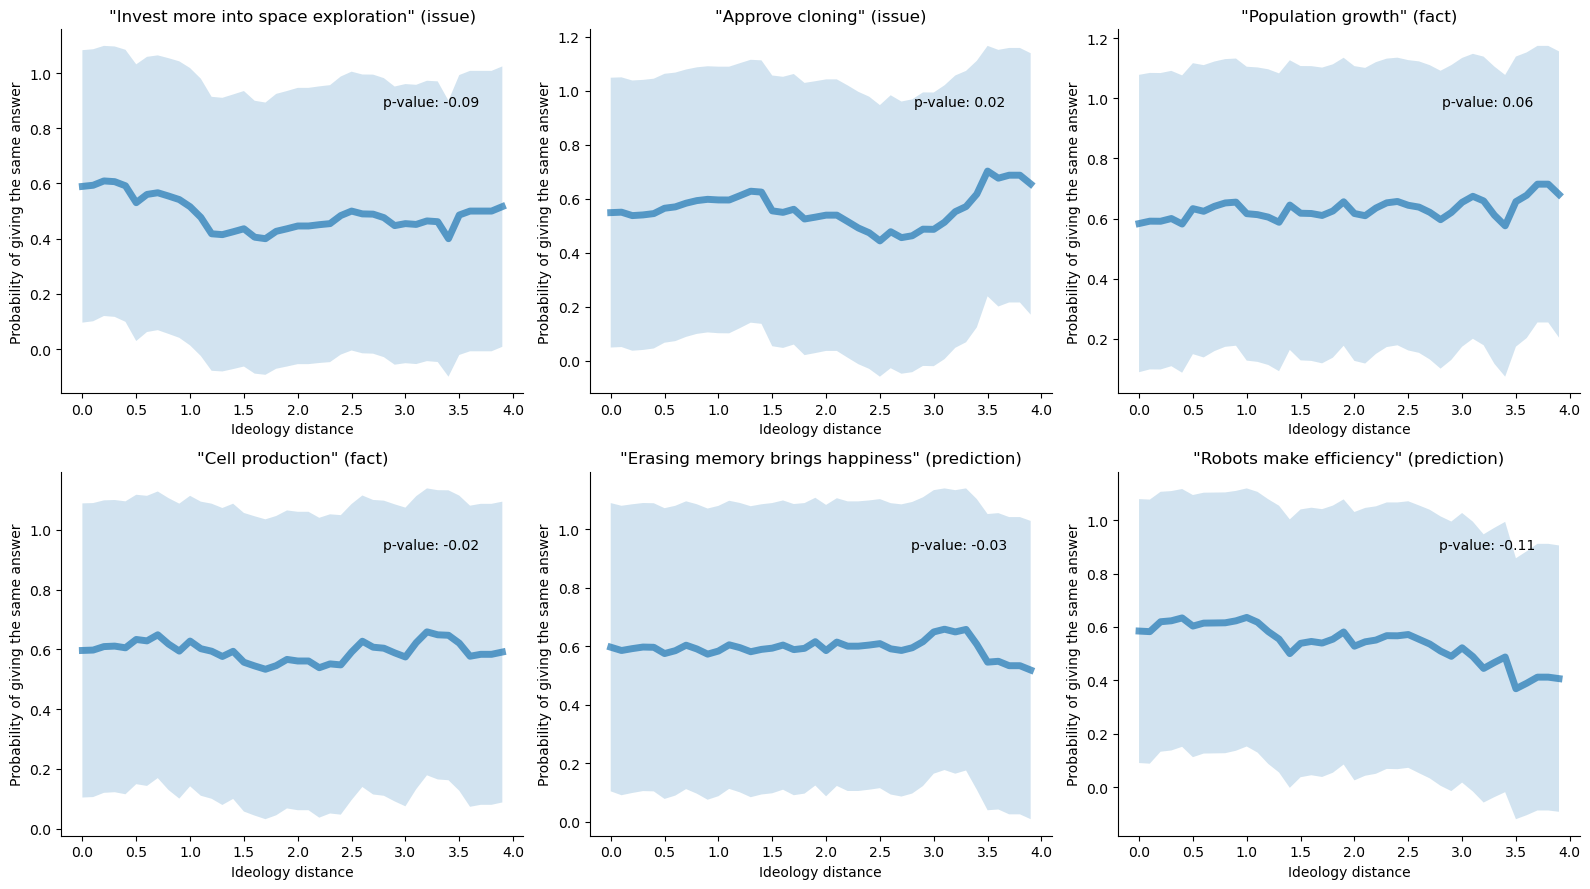

In [67]:
df_not_first = df.loc[(df["who_answers_first"] != 1) & (df["condition"] == 2)]
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
for i in range(6):
    ax = axes[i // 3, i % 3]
    ax.set(
        title = f"{question_title_map[i]}",
        xlabel="Ideology distance",
        ylabel="Probability of giving the same answer",
    )
    df_question = df_not_first.loc[df_not_first["idx_of_question"] == i]
    average, low, high = sliding_average(df_question["ideology_distance"], df_question["same_answer"], 0.5)
    plot_with_std(ax, average, low, high)
    p = pearsonr(df_question["ideology_distance"], df_question["same_answer"])[0]
    ax.text(0.8, 0.8, f"p-value: {p:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
savefig(fig, "ideology_distance_vs_same_answer.pdf")

In [48]:
pearsonr(df_not_first["ideology_distance"], df_not_first["same_answer"])

PearsonRResult(statistic=-0.029592580880484574, pvalue=0.1524168599579401)

In [65]:
df_first = df.loc[(df["who_answers_first"] == 1) & (df["condition"] == 2)]
for i in range(6):
    df_question = df_first.loc[df_first["idx_of_question"] == i]
    print(df_question["same_answer"].mean())

0.46551724137931033
0.5048543689320388
0.46984924623115576
0.5195530726256983
0.5073170731707317
0.47752808988764045
